In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.signal import hilbert, find_peaks
from scipy.signal import  welch, butter, filtfilt
from math import gcd
import math
import os

# 指定你要切换的文件夹路径
data_path = "./data"

# 切换当前工作目录到该路径
os.chdir(data_path)

# 确认是否切换成功
print("当前工作目录:", os.getcwd())

# 选择几种SCI论文常用的颜色：
colors = {
    'red': '#E24A33',
    'blue': '#348ABD',
    'green': '#988ED5',
    'orange': '#FFB000',
    'purple': '#777777',
    'brown': '#CCB974',
    'pink': '#FF69B4',
    'gray': '#999999',
    'cyan': '#00BFFF',
    'yellow': '#FFD700'
}
    


114
[(0, 2), (1, 2), (2, 2), (3, 3), (4, 2), (5, 2), (6, 3), (7, 2), (8, 3), (9, 3), (10, 3), (11, 3), (12, 3), (13, 3), (14, 3), (15, 3), (16, 3), (17, 3), (18, 2), (19, 2), (20, 3), (21, 2), (22, 3), (23, 3), (24, 2), (25, 3), (26, 3), (27, 3), (28, 3), (29, 3), (30, 3), (31, 3), (32, 3), (33, 3), (34, 3), (35, 3), (36, 3), (37, 3), (38, 3), (39, 3), (40, 3), (41, 3), (42, 3), (43, 3), (44, 3), (45, 3), (46, 3), (47, 3), (48, 3), (49, 3), (50, 3), (51, 3), (52, 3), (53, 3), (54, 3), (55, 3), (56, 3), (57, 3), (58, 3), (59, 3), (60, 3), (61, 3), (62, 3), (63, 3), (64, 3), (65, 3), (66, 3), (67, 4), (68, 3), (69, 4), (70, 3), (71, 3), (72, 3), (73, 3), (74, 3), (75, 3), (76, 3), (77, 3), (78, 3), (79, 3), (80, 3), (81, 3), (82, 3), (83, 3), (84, 3), (85, 3), (86, 3), (87, 3), (88, 3), (89, 3), (90, 3), (91, 3), (92, 3), (93, 3), (94, 3), (95, 3), (96, 3), (97, 3), (98, 3), (99, 3), (100, 3), (101, 3), (102, 3), (103, 3), (104, 3), (105, 3), (106, 3), (107, 3), (108, 3), (109, 4), (110,

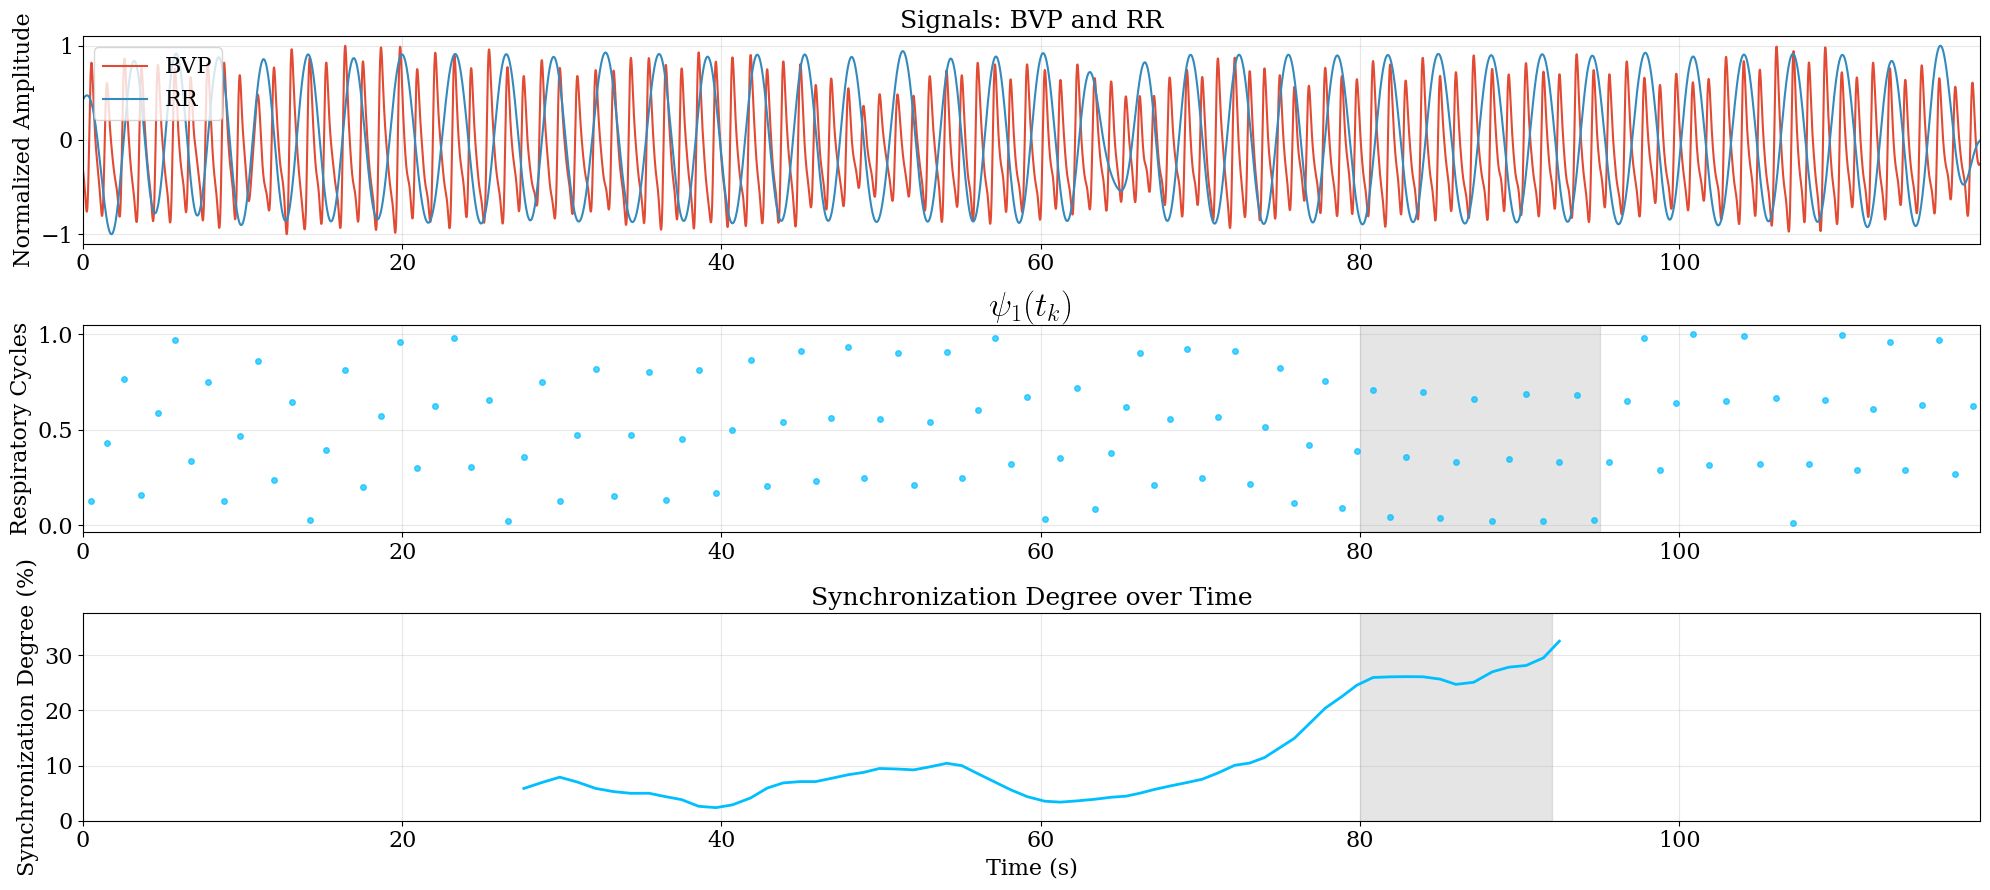

In [ ]:
def simplify_ratio(n, m):
    g = gcd(n, m)
    return (n // g, m // g)  # 返回化简后的(n, m)   
def adjust_phase_to_0_mpi(phi_rr):
    return np.unwrap(phi_rr)  # 使用 np.unwrap() 函数来处理相位跳变问题
def get_hr(y, fs=60, min=30, max=180):
    #fs: 采样频率
    p, q = welch(y, fs, nfft=int(1e6/fs), nperseg=np.min((len(y)-1, 512)))
    return p[(p>min/60)&(p<max/60)][np.argmax(q[(p>min/60)&(p<max/60)])]*60 
from scipy.fft import fft, fftfreq
def calculate_dynamic_n_m_v2(hr_segment, rr_segment, fs=60):
    """
    动态计算 n:m：
      1) 用 get_hr 估计心率 HR_bpm（30–180 bpm）
      2) 用 get_hr 估计呼吸率 VR_bpm（6–60 bpm）
      3) ratio = HR_bpm/VR_bpm，向最近整数取整为 n，m=1
    
    Arguments:
      hr_segment -- 一段心电或脉搏信号（numpy 数组）
      rr_segment -- 一段呼吸或体积信号（numpy 数组）
      fs         -- 采样率 (Hz)
    返回:
      (n, m)     -- 近似的整数比
    """
    # 1) 心率：30–180 bpm
    HR_bpm = get_hr(hr_segment, fs, min=30, max=180)
    # 2) 呼吸率：6–60  bpm
    VR_bpm = get_hr(rr_segment, fs, min=6,  max=30)
    
    # 3) 比值四舍五入
    ratio = HR_bpm / VR_bpm
    n = int(np.round(ratio))
    m = 1
    
    return ratio
def calculate_gamma(sync,ratio_0):
    # Initialize n_m_sync_dict as an empty dictionary
    n_m_sync_dict = {}
    
    n=ratio_0
    #m=1时
    mm=1
    for nn in range((n-1),(n+1)+1):
        if nn <= 1:
            continue #跳过nn=1的情况
        phi_rr_mod=np.mod(sync,2*np.pi*mm)/(2*np.pi)
        window_psi=(2*np.pi/mm) *(np.mod((phi_rr_mod * nn), mm))
        
        cos_sum = (np.sum((np.cos(window_psi)))) / len(window_psi)
        sin_sum = (np.sum((np.sin(window_psi)))) / len(window_psi)
    # 计算同步度
        gamma = cos_sum**2 + sin_sum**2
        n_m_sync_dict[(nn, mm)] = gamma 
    
    #mm=2
    mm=2
    for nn in range((n-1)*2+1,(n+1)*2):
        phi_rr_mod=np.mod(sync,2*np.pi*mm)/(2*np.pi)
        window_psi=(2*np.pi/mm) *(np.mod((phi_rr_mod * nn), mm))
        
        cos_sum = (np.sum((np.cos(window_psi)))) / len(window_psi)
        sin_sum = (np.sum((np.sin(window_psi)))) / len(window_psi)
    # 计算同步度
        gamma = cos_sum**2 + sin_sum**2
        n_m_sync_dict[(nn, mm)] = gamma 
    
    #mm=3
    mm=3
    for nn in range((n-1)*3+1,(n+1)*3):
        phi_rr_mod=np.mod(sync,2*np.pi*mm)/(2*np.pi)
        window_psi=(2*np.pi/mm) *(np.mod((phi_rr_mod * nn), mm))
        
        cos_sum = (np.sum((np.cos(window_psi)))) / len(window_psi)
        sin_sum = (np.sum((np.sin(window_psi)))) / len(window_psi)
    # 计算同步度
        gamma = cos_sum**2 + sin_sum**2
        n_m_sync_dict[(nn, mm)] = gamma 
    
    max_key, max_gamma = max(n_m_sync_dict.items(), key=lambda item: item[1])
    
    
    return max_key, max_gamma
def calculate_dynamic_n_m(hr_segment, rr_segment):
    """根据峰值检测动态调整 n:m"""
    # 获取 hr_segment 和 rr_segment 中的峰值
    hr_peaks, _ = find_peaks(hr_segment, width=10)
    rr_peaks, _ = find_peaks(rr_segment, height=0.5)

    n = len(hr_peaks)  
    m = len(rr_peaks)  

    return round(n/m)
def bandpass_filter(data, lowcut=0.5, highcut=3, fs=30, order=3):
    """Apply a bandpass filter to the data."""
    
    if fs is None or fs <= 0:
        return np.zeros_like(data)
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)
def synchrogram_1(hr_signal, rr_signal, title=""):
    
    hr_min, hr_max = hr_signal.min(), hr_signal.max()
    rr_min, rr_max = rr_signal.min(), rr_signal.max()

    hr_norm = 2*(hr_signal - hr_min) / (hr_max - hr_min)-1
    rr_norm = 2*(rr_signal - rr_min) / (rr_max - rr_min)-1
    # 计算较慢信号（rr_signal）的相位，使用Hilbert变换
    phi_rr = np.angle(hilbert(rr_norm))
    phi_rr = adjust_phase_to_0_mpi(phi_rr)  # 调整相位到 [0, 2πm] 范围
    phi_rr_1 = np.mod(phi_rr, 2 * np.pi )  # 将相位限制在 [0, 2π] 范围内
    phi_rr_2 = np.mod(phi_rr, 4 * np.pi)  # 将相位限制在 [0, 4π] 范围内
    phi_rr_3 = np.mod(phi_rr, 6 * np.pi )  # 将相位限制在 [0, 6π] 范围内
    # 找到较快信号（hr_signal）的峰值位置
    peaks, _ = find_peaks(hr_norm,width=8)  # 找到 hr_signal 的峰值位置
    print(len(peaks))
    #peaks_rr = find_peaks(rr_norm)[0]  # 找到 rr_signal 的峰值位置

    # 在峰值位置提取 rr_signal 的相位
    sync= phi_rr[peaks]  # 提取 rr_signal 的相位
    sync_1 = phi_rr_1[peaks]
    sync_2 = phi_rr_2[peaks]  # 提取 rr_signal 的相位
    sync_3 = phi_rr_3[peaks]  # 提取 rr_signal 的相位
    
    window_size = 600
    ratio_data = []  # 用来保存 (峰值位置, (n, m))
    for i in range(0,len(peaks)): #计算每个峰值位置的 初步猜测的 n:m 比例
        p=peaks[i]
        start = max(0, p - window_size)
        end = min(len(hr_signal), p + window_size)
        hr_seg_local = hr_signal[start:end]
        rr_seg_local = rr_signal[start:end]
        local_n= calculate_dynamic_n_m(hr_seg_local, rr_seg_local)
        ratio_data.append((i, local_n ))
    print(ratio_data)
    gamma_all = []
    max_n_m=[]
    
    N=50
    
    for k in range(N//2,len(peaks)-N//2):
        # 取滑动窗口内的相对相位
        start = int( k - N//2+1)
        end = int(k + N//2+1)
        window_sync = sync[start:end]
        ratio_cur=ratio_data[k][1]
        n_m,gamma_cur=calculate_gamma(window_sync,ratio_cur)
        gamma_all.append(gamma_cur)
        max_n_m.append(n_m)
        
    
    print(f"len(psi_plus):{len(sync)}")
    max_n_m = [simplify_ratio(n, m) for n, m in max_n_m]
    # === 计算同步指标 ===
    
    fs = 60  # 实际采样率
    
    peaks_trimmed = peaks[N//2:len(peaks)-N//2]  # gamma_all 对应的峰值位置

    time = np.arange(len(hr_norm)) / fs 
    # 绘制结果
    fig, axes = plt.subplots(3, 1, figsize=(20, 9))  
    min_val = min(gamma_all)
    max_val = max(gamma_all)
    # 将 peaks 转成以秒为单位
    time_peaks = peaks / fs
    # 绘制同步图
    # First plot: BVP and RR signals
    axes[0].plot(time, hr_norm, color=colors['red'], label='BVP', linewidth=1.5)
    axes[0].plot(time, rr_norm, color=colors['blue'], label='RR', linewidth=1.5)
    axes[0].set_title("Signals: BVP and RR", fontsize=18)
    axes[0].legend(loc='best', fontsize=16)
    axes[0].set_ylabel("Normalized Amplitude", fontsize=16)
    axes[0].grid(True, alpha=0.3)
    axes[0].tick_params(axis='both', labelsize=16)
    axes[0].set_xlim([time[0], time[-1]])
    
    # Second plot: Synchrogram
    axes[1].plot(time_peaks, sync_1/(2*np.pi), "o", markersize=4, color=colors['cyan'], alpha=0.7)
    #plt.rcParams["text.usetex"] = True
    axes[1].set_title(r'$\mathrm{\psi}_1(t_k)$', fontsize=25, fontweight='bold',usetex=True)
    #plt.rcParams["text.usetex"] = False
    axes[1].set_ylabel("Respiratory Cycles", fontsize=16)
    axes[1].grid(True, alpha=0.3)
    axes[1].tick_params(axis='both', labelsize=16)
    axes[1].set_xlim([time[0], time[-1]])
    
    # Add rectangle to highlight 80-95s region in synchrogram
    axes[1].axvspan(80, 95, alpha=0.2, color='gray')
    
    # Third plot: Synchronization degree
    time_peaks_trimmed = time_peaks[N // 2 : len(peaks) - N // 2]
    scaled_gamma_all = [val * 100 for val in gamma_all]
    
    scaled_min_val = min_val * 100
    scaled_max_val = max_val * 100
    start_tick = math.floor(scaled_min_val * 10) / 10
    end_tick = math.ceil(scaled_max_val * 10) / 10
    
    axes[2].set_ylim([max(0, start_tick-5), min(100, end_tick+5)])
    axes[2].set_yticks(np.arange(int(max(0, start_tick-5)), int(min(100, end_tick+5))+1, 10))
    axes[2].set_xlim([time[0], time[-1]])
    axes[2].plot(time_peaks_trimmed, scaled_gamma_all, '-', color=colors['cyan'], linewidth=2)
    
    # Add rectangle to highlight 80-95s region in sync degree plot
    axes[2].axvspan(80, 92, alpha=0.2, color='gray')
    
    axes[2].set_title("Synchronization Degree over Time", fontsize=18)
    axes[2].set_xlabel("Time (s)", fontsize=16)
    axes[2].set_ylabel("Synchronization Degree (%)", fontsize=16)
    axes[2].grid(True, alpha=0.3)
    axes[2].tick_params(axis='both', labelsize=16)

    
    plt.tight_layout()

    plt.savefig("synchrogram_1.pdf", dpi=300, bbox_inches='tight')
    plt.show()

hr_pattern = r"060201_v01_hr_0.npy"
rr_pattern = r"060201_v01_rr_0.npy"
bvp_signal= np.load(hr_pattern)
rr_signal = np.load(rr_pattern)
bvp_signal = bandpass_filter(bvp_signal, lowcut=0.5, highcut=3, fs=60, order=3)
rr_signal = bandpass_filter(rr_signal, lowcut=0.1, highcut=0.5, fs=60, order=3)
synchrogram_1(bvp_signal, rr_signal)

MRA_DEC p-value: 0.0000
SAP_DEC p-value: 0.0002
MRA_ACC p-value: 0.0000
SAP_ACC p-value: 0.0003
num_sync: statistic=9.000, p-value=0.00195
min_gamma: statistic=17.000, p-value=0.00039
max_gamma: statistic=47.000, p-value=0.02958


c:\Anaconda\envs\py_class\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


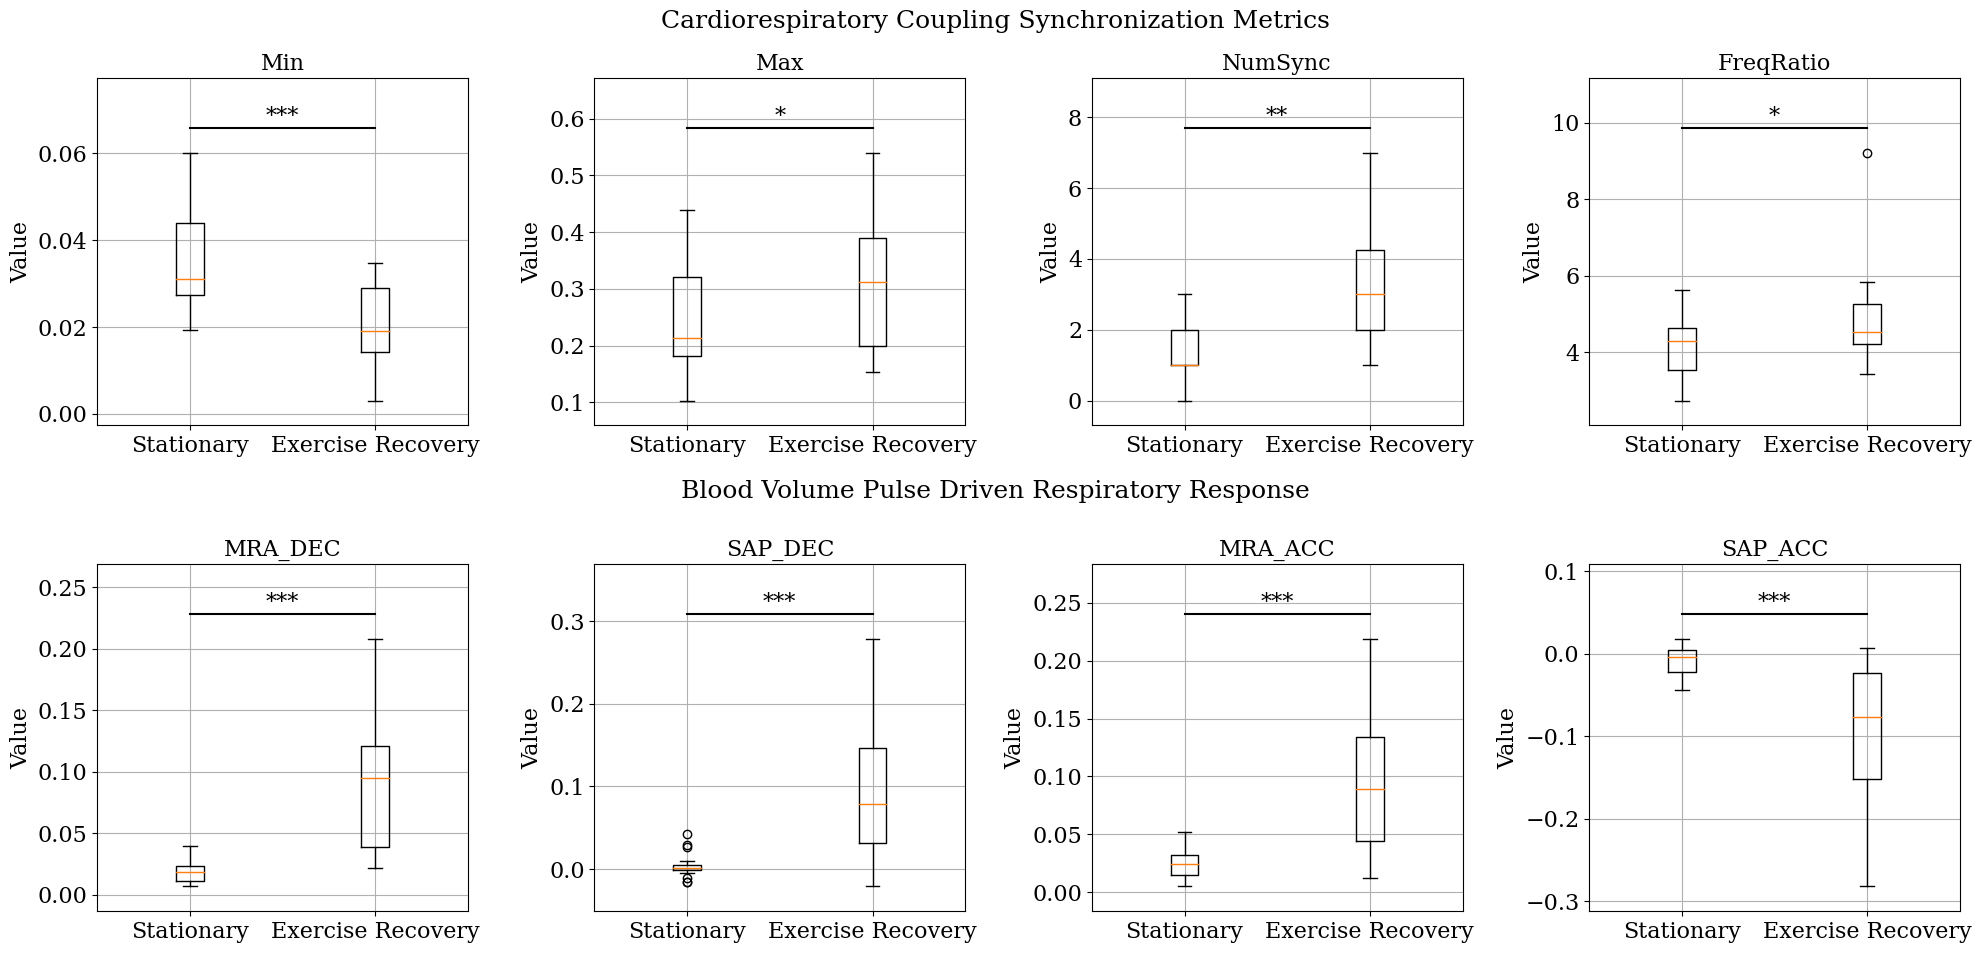

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kruskal, wilcoxon
import numpy as np  

MRA_DEC=np.load(r"MRA_DEC_T=0.4.npy")
SAP_ACC=np.load(r"SAP_ACC_T=0.4.npy")
MRA_ACC=np.load(r"MRA_ACC_T=0.4.npy")
SAP_DEC=np.load(r"SAP_DEC_T=0.4.npy")
rest1=np.concatenate([MRA_DEC[0],MRA_DEC[2]])
recovery1=np.concatenate([MRA_DEC[1],MRA_DEC[3]])
rest2=np.concatenate([SAP_DEC[0],SAP_DEC[2]])
recovery2=np.concatenate([SAP_DEC[1],SAP_DEC[3]])               
rest3=np.concatenate([MRA_ACC[0],MRA_ACC[2]])
recovery3=np.concatenate([MRA_ACC[1],MRA_ACC[3]])
rest4=np.concatenate([SAP_ACC[0],SAP_ACC[2]])
recovery4=np.concatenate([SAP_ACC[1],SAP_ACC[3]])
state1,p1=wilcoxon(rest1,recovery1)
state2,p2=wilcoxon(rest2,recovery2)
state3,p3=wilcoxon(rest3,recovery3)
state4,p4=wilcoxon(rest4,recovery4)
print(f"MRA_DEC p-value: {p1:.4f}")
print(f"SAP_DEC p-value: {p2:.4f}")
print(f"MRA_ACC p-value: {p3:.4f}")
print(f"SAP_ACC p-value: {p4:.4f}")


import numpy as np  
from scipy.stats import kruskal, wilcoxon

min_gamma = np.load("min_gamma.npy")
max_gamma = np.load("max_gamma.npy")
num_sync = np.load("num_sync.npy")
rest1 = np.concatenate([num_sync[0], num_sync[2]])
recovery1 = np.concatenate([num_sync[1], num_sync[3]])
rest2 = np.concatenate([min_gamma[0], min_gamma[2]])
recovery2 = np.concatenate([min_gamma[1], min_gamma[3]])
rest3 = np.concatenate([max_gamma[0], max_gamma[2]])
recovery3 = np.concatenate([max_gamma[1], max_gamma[3]])
#print("Rest:",rest1, rest2, rest3)
#print("Recovery:",recovery1, recovery2, recovery3)
# 进行 Wilcoxon 配对检验
stat1, p_val1 = wilcoxon(rest1, recovery1, alternative='two-sided')
stat2, p_val2 = wilcoxon(rest2, recovery2, alternative='two-sided')
stat3, p_val3 = wilcoxon(rest3, recovery3, alternative='two-sided')
print(f"num_sync: statistic={stat1:.3f}, p-value={p_val1:.5f}")
print(f"min_gamma: statistic={stat2:.3f}, p-value={p_val2:.5f}")
print(f"max_gamma: statistic={stat3:.3f}, p-value={p_val3:.5f}")

# p 值转星号
def p_to_asterisks(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'ns'

# 合并状态 1 和 3, 2 和 4
def merge_states(data):
    return [np.concatenate([data[0], data[2]]),
            np.concatenate([data[1], data[3]])]

# 加载数据
min_gamma = merge_states(np.load("min_gamma.npy"))
max_gamma = merge_states(np.load("max_gamma.npy"))
num_sync  = merge_states(np.load("num_sync.npy"))
avg_ratio = merge_states(np.load("avg_ratio.npy"))

MRA_DEC = merge_states(np.load("MRA_DEC_T=0.4.npy"))
SAP_DEC = merge_states(np.load("SAP_DEC_T=0.4.npy"))
MRA_ACC = merge_states(np.load("MRA_ACC_T=0.4.npy"))
SAP_ACC = merge_states(np.load("SAP_ACC_T=0.4.npy"))

# 数据和 p 值
metrics_upper = {
    "Min": min_gamma,
    "Max": max_gamma,
    "NumSync": num_sync,
    "FreqRatio": avg_ratio
}
p_values_upper = {
    "Min": 0.00039,
    "Max": 0.02958,
    "NumSync": 0.00195,
    "FreqRatio": 0.048441
}
metrics_lower = {
    "MRA_DEC": MRA_DEC,
    "SAP_DEC": SAP_DEC,
    "MRA_ACC": MRA_ACC,
    "SAP_ACC": SAP_ACC
}
p_values_lower = {
    'MRA_DEC':  0.000004,
    'SAP_DEC': 0.000210,
    'MRA_ACC': 0.000048,
    'SAP_ACC':  0.000322
}

# 创建 2 行 4 列子图
fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # Increased figure height for more spacing

# 添加两行图的标题
fig.text(0.5, 0.93, 'Cardiorespiratory Coupling Synchronization Metrics', 
         ha='center', fontsize=18)
fig.text(0.5, 0.46, 'Blood Volume Pulse Driven Respiratory Response',  # Moved title position down
         ha='center', fontsize=18)

# 第一行：Min, Max, NumSync
for i, (name, data) in enumerate(metrics_upper.items()):
    ax = axes[0, i]
    ax.boxplot(data, labels=['Stationary', 'Exercise Recovery'])
    ax.set_title(name, fontsize=16)
    ax.set_ylabel('Value', fontsize=16)
    ax.tick_params(axis='both', labelsize=16)
    ax.grid(True)
    
    y_max = max(np.max(data[0]), np.max(data[1]))
    y_min = min(np.min(data[0]), np.min(data[1]))
    height = y_max + 0.1 * (y_max - y_min)
    ax.set_ylim([y_min - 0.1 * (y_max - y_min), y_max + 0.3 * (y_max - y_min)])
    ax.plot([1, 2], [height, height], color='black')
    ax.text(1.5, height,
            f"{p_to_asterisks(p_values_upper[name])}",
            ha='center', va='bottom', fontsize=16)

for i, (name, data) in enumerate(metrics_lower.items()):
    ax = axes[1, i]
    ax.boxplot(data, labels=['Stationary', 'Exercise Recovery'])
    ax.set_title(name, fontsize=16)
    ax.set_ylabel('Value', fontsize=16)
    ax.tick_params(axis='both', labelsize=16)
    ax.grid(True)

    y_max = max(np.max(data[0]), np.max(data[1]))
    y_min = min(np.min(data[0]), np.min(data[1]))
    height = y_max + 0.1 * (y_max - y_min)
    ax.set_ylim([y_min - 0.1 * (y_max - y_min), y_max + 0.3 * (y_max - y_min)])
    ax.plot([1, 2], [height, height], color='black')
    ax.text(1.5, height,
            f"{p_to_asterisks(p_values_lower[name])}",
            ha='center', va='bottom', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.92])  # Adjusted rect to leave more space for titles
plt.subplots_adjust(hspace=0.4)  # Added vertical space between rows
plt.savefig("box.pdf", dpi=300, bbox_inches='tight')
plt.show()


找到 3543 个完整的锚点片段。
找到 3351 个完整的锚点片段。
找到 3543 个完整的锚点片段。
找到 3351 个完整的锚点片段。


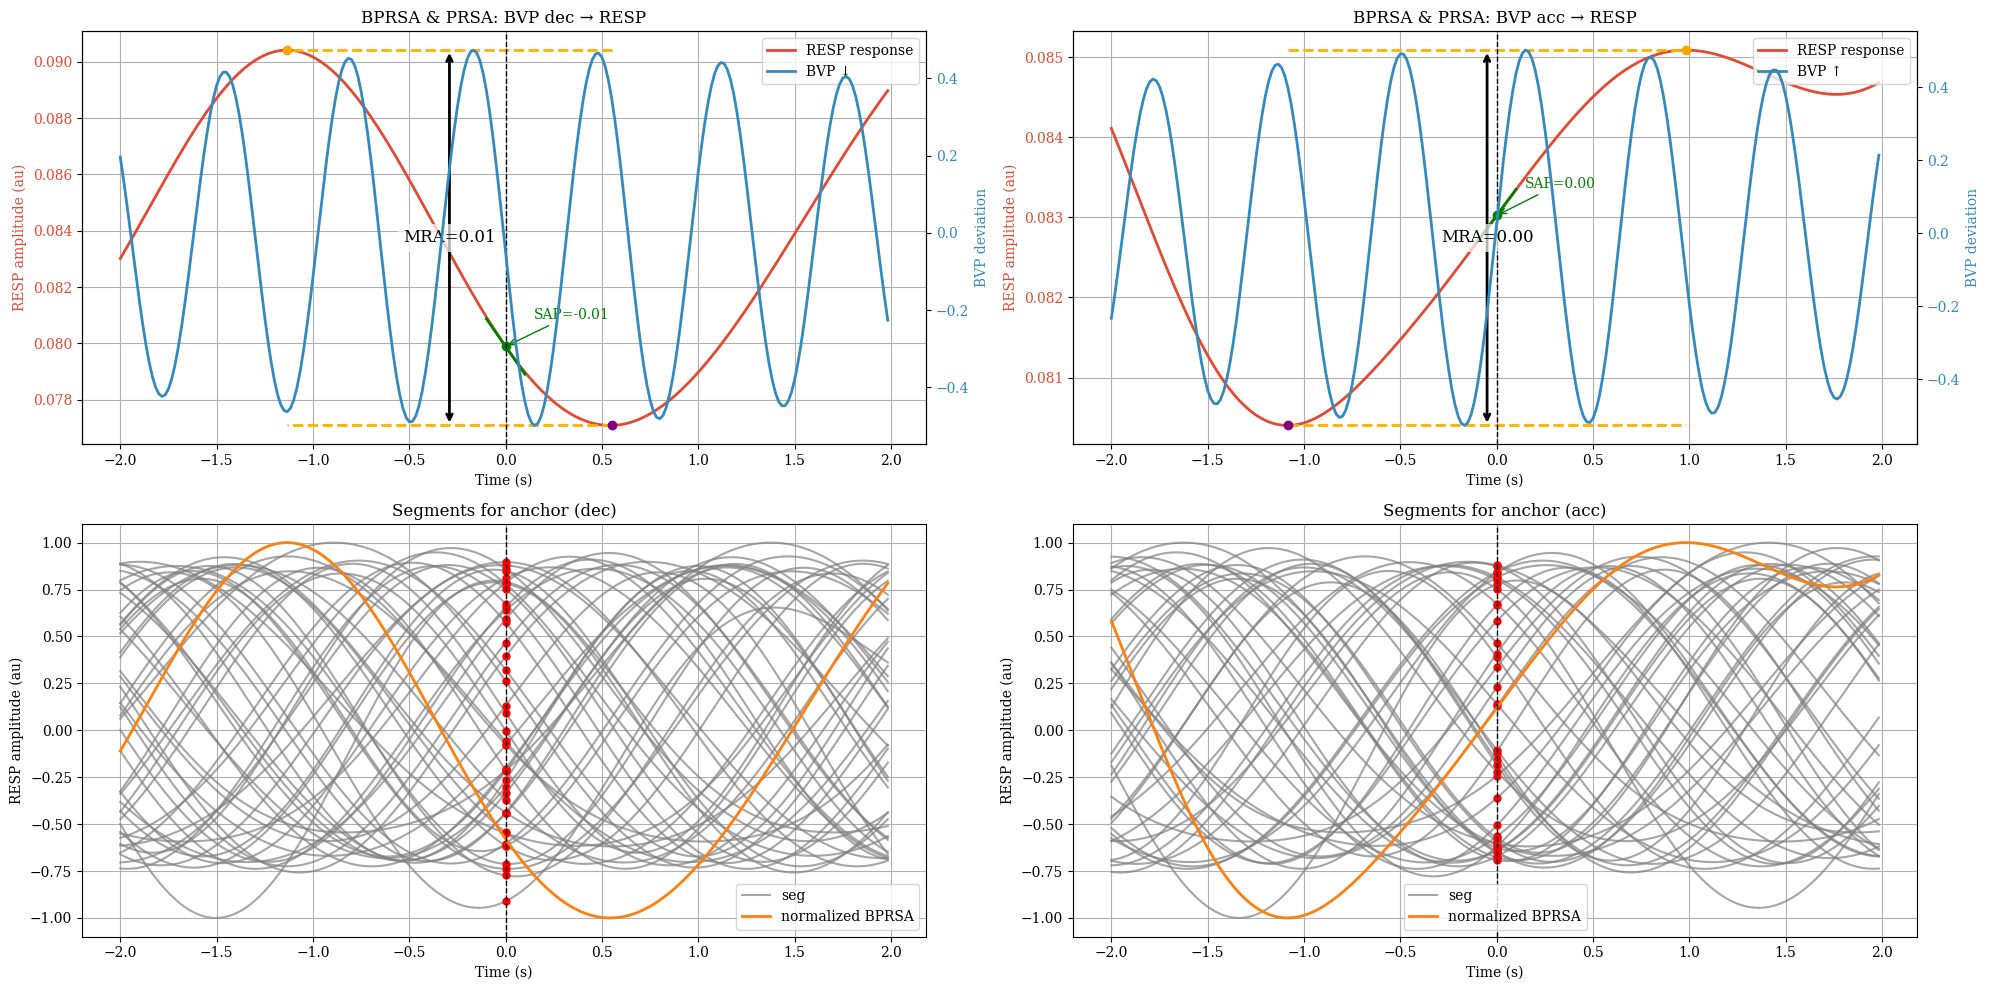

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, butter, filtfilt
#归一化函数（-1,1）
def normalize(x):
    x = (x - np.min(x)) / (np.max(x) - np.min(x))
    x = x * 2 - 1
    return x
def plot_hr_with_anchors(hr, anchors, fs, title="HR Signal with Anchors"):
    t = np.arange(len(hr)) / fs
    plt.figure(figsize=(25, 6))
    plt.plot(t, hr, label='HR Signal')
    plt.plot(t[anchors], hr[anchors], 'ro', label='Anchors', markersize=3)
    plt.xlabel('Time (s)')
    plt.ylabel('HR (normalized)')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
import os
    
def plot_each_seg(segs, wL, wH, fs, title_prefix="Segment", save_dir=r"C:\Users\康萌\Desktop\PILab_Internship\呼吸信号片段"):
    # 创建保存图片的文件夹（如果不存在）
    os.makedirs(save_dir, exist_ok=True)
    t_win = np.arange(-wL, wH) / fs
    for i, seg in enumerate(segs):
        plt.figure(figsize=(6, 3))
        plt.plot(t_win, seg, color='C0')
        plt.plot(0, seg[wL], 'ro', markersize=6, label='Anchor')
        plt.axvline(0, color='k', ls='--', lw=1)
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.title(f"{title_prefix} #{i+1}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        # 保存图片到文件夹
        plt.savefig(os.path.join(save_dir, f"{title_prefix}_{i+1}.png"))
        plt.close()  # 关闭当前图片，防止内存占用过多
def plot_segs_with_anchors_ax(ax, segs, wL, wH, fs, bprsa=None, title="All Segments with Anchors", step=80):
    """
    在指定 ax 上绘制部分 segs 及 bprsa 曲线
    """
    t_win = np.arange(-wL, wH) / fs  # 每段的时间轴
    for i in range(0, len(segs), step):
        seg = segs[i]
        ax.plot(t_win, seg, alpha=0.7, color='gray', label='seg' if i == 0 else None)
        ax.plot(0, seg[wL], 'ro', markersize=5)
    if bprsa is not None:
        ax.plot(t_win, bprsa, color='C1', lw=2, label='normalized BPRSA')
    ax.axvline(0, color='k', ls='--', lw=1)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel(f'RESP amplitude (au)')
    ax.set_title(title)
    ax.legend()
    ax.grid(True)
def plot_segs_with_anchors(segs, wL, wH, fs, bprsa, title="All Segments with Anchors"):
    t_win = np.arange(-wL, wH) / fs  # 每段的时间轴
    plt.figure(figsize=(20, 6))
    # 只画索引为50的倍数的片段
    for i in range(0, len(segs), 80):
        seg = segs[i]
        plt.plot(t_win, seg, alpha=0.7, color='gray', label=f'seg' if i == 0 else None)
        plt.plot(0, seg[wL], 'ro', markersize=5)
    if bprsa is not None:
        plt.plot(t_win, bprsa, color='C1', lw=2, label='normalized BPRSA')
    plt.axvline(0, color='k', ls='--', lw=1)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def find_anchors(hr, T_pts, kind='dec'):
    
    #hr: 心率序列 (bpm)
    #T_pts: 前后窗口大小 (样本点数)
    #kind: 'dec' 找 HR↓，'acc' 找 HR↑
    
    N = len(hr)
    idxs = np.arange(T_pts, N - T_pts)
    back = np.array([hr[i-T_pts:i].mean() for i in idxs])
    forw = np.array([hr[i:i+T_pts].mean() for i in idxs])
    if kind == 'dec':
        mask = forw < back
    else:
        mask = forw > back
    #plot_hr_with_anchors(hr, idxs[mask], fs=1, title=f"Anchors for {kind} events T={T_pts/60} s")
    return idxs[mask]
    """
def find_anchors(hr, kind='dec'):
    hr = np.asarray(hr)
    if kind == 'dec':
        mask = hr[1:] < hr[:-1]
    else:
        mask = hr[1:] > hr[:-1]
    anchors = np.where(mask)[0] + 1  # +1 是因为比较的是后一个点
    plot_hr_with_anchors(hr, anchors, fs=1, title=f"Anchors for {kind} events")
    return anchors"""


def find_centered_anchors(hr, kind='dec'):
    """
    只检测每段连续上升沿或下降沿的最中心点作为锚点
    """
    hr = np.asarray(hr)
    if kind == 'dec':
        mask = hr[1:] < hr[:-1]
    else:
        mask = hr[1:] > hr[:-1]
    all_anchors = np.where(mask)[0] + 1

    # 如果没有锚点，直接返回
    if len(all_anchors) == 0:
        return np.array([], dtype=int)

    # 找到不连续的地方进行分组
    splits = np.where(np.diff(all_anchors) > 1)[0] + 1
    groups = np.split(all_anchors, splits)

    # 每组取最中心的点
    center_anchors = []
    for group in groups:
        if len(group) > 0:
            center_idx = group[len(group)//2]
            center_anchors.append(center_idx)
    center_anchors = np.array(center_anchors)

    #plot_hr_with_anchors(hr, center_anchors, fs=1, title=f"Centered Anchors for {kind} events")
    return center_anchors

def bprsa_localmean(anchor_sig, target_sig, fs, T, L, H, direction='dec'):
    
    #  转换 T 为样本点数
    T_pts = int(T * fs)
    anchors = find_anchors(anchor_sig,T_pts,kind=direction)
    #plot_hr_with_anchors(target_sig, anchors, fs, title=f"Anchors for {direction} events T={T} s")
    #  截取并平均 target_sig 片段
    wL, wH = int(L * fs), int(H * fs)
    segs = []
    for a in anchors:
        if a - wL >= 0 and a + wH < len(target_sig):
            segs.append(target_sig[a-wL:a+wH])
            '''
    for a in anchors:
        if a - wL >= 0 and a + wH < len(target_sig):
            seg = target_sig[a-wL:a+wH]
            seg = seg - seg[wL]  # 对齐锚点幅值
            segs.append(seg)'''
    segs = np.array(segs)
    #plot_each_seg(segs, wL, wH, fs, title_prefix="Segment for BPRSA")
    #plot_segs_with_anchors(segs, wL, wH, fs, title=f"All Segments for {direction} events T={T} s")
    if segs.size == 0:
        raise RuntimeError("没有找到任何完整的锚点片段，请检查 T, L, H 设置。")
    print(f"找到 {len(segs)} 个完整的锚点片段。")
    bprsa_curve = segs.mean(axis=0)
    t_win = np.arange(-wL, wH) / fs
    #plot_segs_with_anchors(segs, wL, wH, fs, normalize(bprsa_curve), title=f"BPRSA for {direction} events T={T} s")
    # 计算归一化 PSD
    # 去直流
    sig = bprsa_curve - bprsa_curve.mean()
    f, Pxx = welch(sig, fs=fs, nperseg=min(1024, len(sig)))
    mask = (f >= 0) & (f <= 3)
    f_0_3 = f[mask]
    Pxx_0_3 = Pxx[mask]
    Pxx_norm = Pxx_0_3 / np.trapz(Pxx_0_3, f_0_3) * 100
    #Pxx_norm = Pxx / np.trapz(Pxx, f) * 100
    return t_win, bprsa_curve,segs


def plot_bprsa_prsa(ax, t_bprsa, bprsa, t_prsa, prsa, kind='dec', signal='BVP', target_signal='RESP'):
    """
    Plot both BPRSA and PRSA curves on the same axis with different scales
    并标记MRA和SAP
    """
    # 创建主y轴
    color1 = colors['red']
    color2 = colors['blue']
    
    # BPRSA曲线使用主y轴
    line1 = ax.plot(t_bprsa, bprsa, lw=2, color=color1, label=f'{target_signal} response')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel(f'{target_signal} amplitude (au)', color=color1)
    ax.tick_params(axis='y', labelcolor=color1)
    
    # ----------- MRA标记 -----------
    idx_max = np.argmax(bprsa)
    idx_min = np.argmin(bprsa)
    # 横线
    ax.hlines(bprsa[idx_max], t_bprsa[idx_min], t_bprsa[idx_max], color=colors['orange'], linestyles='--', lw=2)
    ax.hlines(bprsa[idx_min], t_bprsa[idx_min], t_bprsa[idx_max], color=colors['orange'], linestyles='--', lw=2)
    # 双箭头
    mid_x = 0.5 * (t_bprsa[idx_max] + t_bprsa[idx_min])
    ax.annotate('', xy=(mid_x, bprsa[idx_max]), xytext=(mid_x, bprsa[idx_min]),
                arrowprops=dict(arrowstyle='<->', color='black', lw=2))
    mra_val = bprsa[idx_max] - bprsa[idx_min]
    ax.text(mid_x, 0.5*(bprsa[idx_max]+bprsa[idx_min]), 
            f'MRA={mra_val:.2f}', color='black', fontsize=12, ha='center', va='center',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    # Max/Min点
    ax.plot(t_bprsa[idx_max], bprsa[idx_max], 'o', color='orange', label='Max')
    ax.plot(t_bprsa[idx_min], bprsa[idx_min], 'o', color='purple', label='Min')

    # ----------- SAP标记 -----------
    center_idx = np.argmin(np.abs(t_bprsa))
    if 0 < center_idx < len(bprsa)-1:
        SAP = (bprsa[center_idx+1] - bprsa[center_idx-1]) / (t_bprsa[center_idx+1] - t_bprsa[center_idx-1])
        delta = 0.1  # 控制切线长度
        x_sap = np.array([t_bprsa[center_idx]-delta, t_bprsa[center_idx]+delta])
        y_sap = bprsa[center_idx] + SAP * (x_sap - t_bprsa[center_idx])
        ax.plot(x_sap, y_sap, color='green', lw=2, label='SAP')
        ax.plot(t_bprsa[center_idx], bprsa[center_idx], 'o', color='green')
    ax.annotate(
        f'SAP={SAP:.2f}',
        xy=(t_bprsa[center_idx], bprsa[center_idx]),
        xytext=(20, 20),  # (x, y) 偏移20个像素
        textcoords='offset points',
        arrowprops=dict(arrowstyle='->', color='green'),
        color='green',
        fontsize=10
    )
    
    # PRSA曲线使用次y轴
    ax_twin = ax.twinx()
    line2 = ax_twin.plot(t_prsa, prsa, lw=2, color=color2, label=f"{signal} {'↓' if kind == 'dec' else '↑'}")
    ax_twin.set_ylabel(f'{signal} deviation', color=color2)
    ax_twin.tick_params(axis='y', labelcolor=color2)
    
    # 垂直线标记0点
    ax.axvline(0, color='k', lw=1, ls='--')
    
    # 设置标题
    if signal == 'RESP':
        title = f'BPRSA & PRSA: {signal} {"expiratory" if kind == "dec" else "inspiratory"} → {target_signal}'
    else:
        title = f'BPRSA & PRSA: {signal} {"dec" if kind == "dec" else "acc"} → {target_signal}'
    ax.set_title(title)
    
    # 合并图例
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc='upper right')
    ax.grid(True)


hr_pattern = r"060204_v01_hr_0.npy"
rr_pattern = r"060204_v01_rr_0.npy"
hr = np.load(hr_pattern)
resp = np.load(rr_pattern)
hr = bandpass_filter(hr, lowcut=0.5, highcut=3, fs=60, order=3)
resp = bandpass_filter(resp, lowcut=0.1, highcut=0.5, fs=60, order=3)

hr = normalize(hr)
resp = normalize(resp)
fs = 60
T_secs = 0.4       
T_pts = int(T_secs * fs)
L_secs = H_secs = 2    # 前后各1秒

# 分别计算 dec、acc 情形下的 BPRSA、PRSA
t_bvp_dec,   prsa_bvp1,segs_dec_hr = bprsa_localmean(hr, hr,   fs, T_secs, L_secs, H_secs, direction='dec')
t_bvp_acc,   prsa_bvp2 ,segs_acc_hr= bprsa_localmean(hr, hr,   fs, T_secs, L_secs, H_secs, direction='acc')
t_bprsa_dec, bprsa1 ,segs_dec_resp   = bprsa_localmean(hr, resp, fs, T_secs, L_secs, H_secs, direction='dec')
t_bprsa_acc, bprsa2 ,segs_acc_resp   = bprsa_localmean(hr, resp, fs, T_secs, L_secs, H_secs, direction='acc')

# 创建 figure + 2个子图 (1行×2列)
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

# 左侧绘制 dec
plot_bprsa_prsa(
    ax=axes[0,0],
    t_bprsa=t_bprsa_dec, bprsa=bprsa1, 
    t_prsa=t_bvp_dec, prsa=prsa_bvp1,
    kind='dec', signal='BVP', target_signal='RESP'
)

# 右侧绘制 acc
plot_bprsa_prsa(
    ax=axes[0,1],
    t_bprsa=t_bprsa_acc, bprsa=bprsa2,
    t_prsa=t_bvp_acc, prsa=prsa_bvp2,
    kind='acc', signal='BVP', target_signal='RESP'
)
plot_segs_with_anchors_ax(
    ax=axes[1,0],
    segs=segs_dec_resp, wL=int(L_secs * fs), wH=int(H_secs * fs), fs=fs,
    bprsa=normalize(bprsa1),
    title="Segments for anchor (dec)"
)
plot_segs_with_anchors_ax(
    ax=axes[1,1],
    segs=segs_acc_resp, wL=int(L_secs * fs), wH=int(H_secs * fs), fs=fs,
    bprsa=normalize(bprsa2),
    title="Segments for anchor (acc)"
)

plt.tight_layout()
plt.savefig("bprsa_prsa.pdf", dpi=300, bbox_inches='tight')
plt.show()

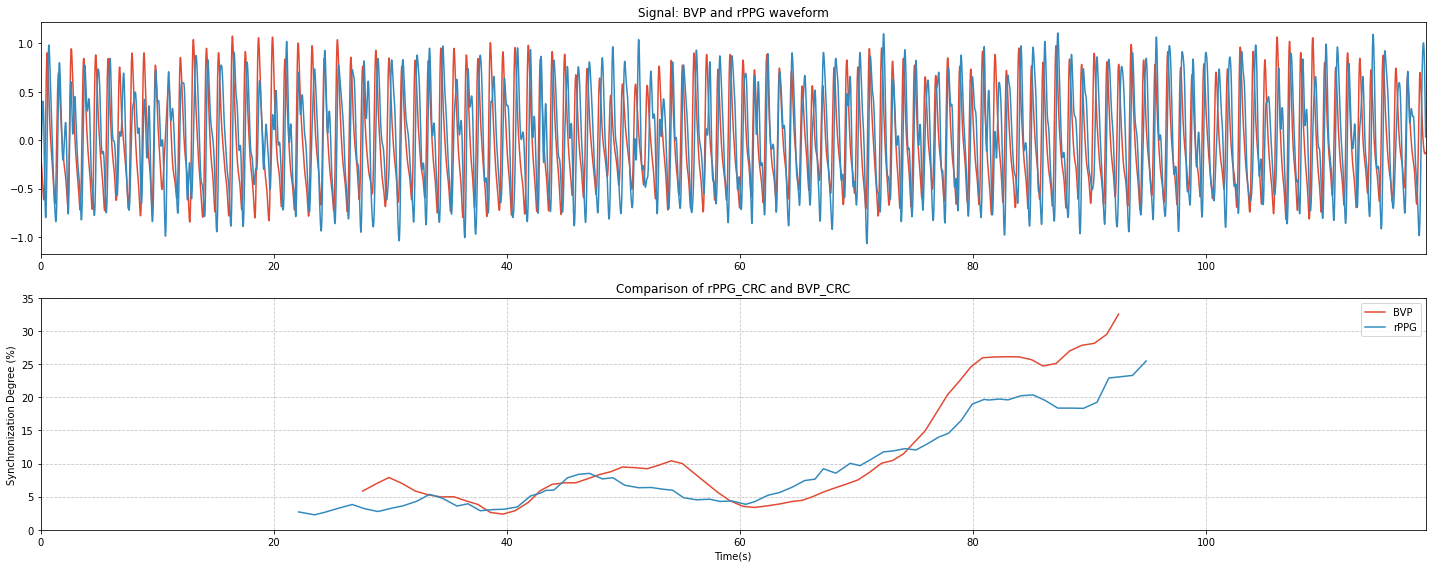

In [22]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from scipy.signal import  welch, butter, filtfilt
def normalize(x):
    x = (x - np.min(x)) / (np.max(x) - np.min(x))
    x = x * 2 - 1
    return x

def bandpass_filter(data, lowcut=0.5, highcut=3, fs=30, order=3):
    """Apply a bandpass filter to the data."""
    
    if fs is None or fs <= 0:
        return np.zeros_like(data)
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)
rppg_rr_gamma_all=r"bvp_rr_v01_gamma_all.npy"
bvp_rr_gamma_all=r"hr_rr_v01_gamma_all.npy"
bvp_time=r"hr_rr_v01_time_gamma.npy"
rppg_time=r"bvp_rr_v01_time_gamma.npy"
rppg_wave= r"060201_v01_bvp.npy"
bvp_wave = r"060201_v01_hr_0.npy"
rppg_wave=np.load(rppg_wave)
bvp_wave = np.load(bvp_wave)
rppg_wave = normalize(rppg_wave)
bvp_wave = normalize(bvp_wave)
rppg_wave= bandpass_filter(rppg_wave, lowcut=0.5, highcut=3, fs=60, order=3)
bvp_wave = bandpass_filter(bvp_wave, lowcut=0.5, highcut=3, fs=60, order=3)

rppg_data = np.load(rppg_rr_gamma_all)
bvp_data = np.load(bvp_rr_gamma_all)
bvp_time = np.load(bvp_time)
rppg_time = np.load(rppg_time)
time=np.arange(len(rppg_wave))/60
fig, axes = plt.subplots(2, 1, figsize=(20, 8))

# BVP 和 rPPG 信号
axes[0].plot(time, bvp_wave, color=colors['red'], label='BVP')
axes[0].plot(time, rppg_wave, color=colors['blue'], label='rPPG')

axes[0].set_title("Signal: BVP and rPPG waveform")
# axes[0].legend()
axes[0].set_xlim([time[0], time[-1]])

# BVP_CRC 和 rPPG_CRC 
axes[1].plot(bvp_time, bvp_data * 100, color=colors['red'], label='BVP')
axes[1].plot(rppg_time, rppg_data * 100, color=colors['blue'], label='rPPG')

axes[1].set_xlabel('Time(s)')
axes[1].set_ylabel('Synchronization Degree (%)')
axes[1].set_ylim(0, 35)
# axes[1].set_xlim(0, 120)
axes[1].set_title('Comparison of rPPG_CRC and BVP_CRC')
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].set_xlim([time[0], time[-1]])

plt.tight_layout()
plt.savefig("bvp_rppg.pdf", dpi=300, bbox_inches='tight')
plt.show()

